In [1]:
from ema import read

In [2]:
meal_info = read.all_meal_info()

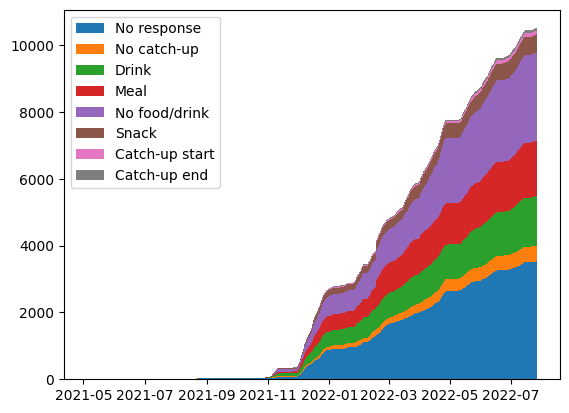

In [3]:
"""
Plot a cumulative histogram showing the number of each type of meal

"""
import pandas as pd
import matplotlib.pyplot as plt

min_time, max_time = meal_info.index.min(), meal_info.index.max()

fig, axis = plt.subplots()
bins = pd.date_range(min_time, max_time, freq="1H")

labels = meal_info["meal_type"].unique()
data = [meal_info[meal_info["meal_type"] == meal_type].index for meal_type in labels]
axis.hist(data, bins=bins, stacked=True, label=labels, cumulative=True)

axis.legend()

In [4]:
meal_info.head()

,x_id,meal_type,portion_size,utensil,location,week_day,p_id,ramadanstart,ramadanend,firstdate,lastdate,ramadanflag_whole_period,ramadanflag_part_period
Datetime,,,,,,,,,,,,,
2022-06-08 11:39:38,701,No response,No response,No response,No response,Wednesday,9891,03apr2022,01may2022,8 Jun 22,13 Jul 22,0,0
2022-06-14 11:45:05,702,No response,No response,No response,No response,Tuesday,9891,03apr2022,01may2022,8 Jun 22,13 Jul 22,0,0
2022-06-21 11:04:01,703,No response,No response,No response,No response,Tuesday,9891,03apr2022,01may2022,8 Jun 22,13 Jul 22,0,0
2022-06-21 12:06:01,704,No response,No response,No response,No response,Tuesday,9891,03apr2022,01may2022,8 Jun 22,13 Jul 22,0,0
2022-07-05 16:26:09,705,No catch-up,No response,No response,No response,Tuesday,9891,03apr2022,01may2022,8 Jun 22,13 Jul 22,0,0


In [5]:
import numpy as np

# Find each unique user
p_ids = meal_info["p_id"].unique()

# Find the first date for each participant
first_dates = []
for p_id in p_ids:
    dates = pd.unique(meal_info[meal_info["p_id"] == p_id]["firstdate"])
    assert len(dates) == 1, f"Multiple first dates for participant {p_id}"

    first_dates.append(pd.to_datetime(dates[0], format=r"%d %b %y"))

first_dates = pd.Series(first_dates)

# build up a matrix of participant ids and non-response rate
non_response_matrix = np.ones((len(p_ids), 8)) * np.nan
response_matrix = np.ones((len(p_ids), 8)) * np.nan

# For each participant, find the non-response rate for each of the eight days following their first recording
for p_id, start_date, non_response_row, response_row in zip(
    p_ids, first_dates, non_response_matrix, response_matrix
):
    # Slice the dataframe to find the meals recorded by this participant
    this_participant = meal_info[meal_info["p_id"] == p_id]

    # Find the non-response rate for each day
    for i in range(8):
        date = start_date + pd.Timedelta(days=i)
        this_date = this_participant[this_participant.index.date == date.date()]

        # Find the number of "no response" entries
        negative_response = ["No response"]
        n_no_response = np.sum(this_date["meal_type"].isin(negative_response))

        non_response_row[i] = n_no_response

        # Find the number of "Drink", "Meal", "Snack", "No food/drink" entries
        positive_response = ["Drink", "Meal", "Snack", "No food/drink"]
        n_response = np.sum(this_date["meal_type"].isin(positive_response))

        response_row[i] = n_response

        # Error if there's anything else
        ignore_response = ["No catch-up", "Catch-up start", "Catch-up end"]
        assert (
            this_date["meal_type"]
            .isin(ignore_response + positive_response + negative_response)
            .values.all()
        ), "Unexpected meal type encountered"

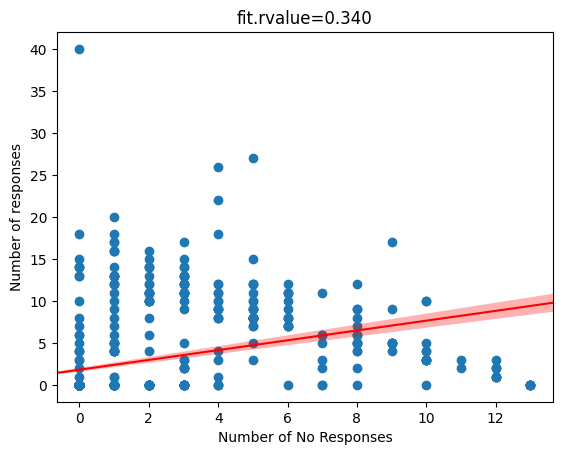

In [6]:
"""
Scatter plot of response rate vs. non-response rate for each participant on each day of the study

"""
from scipy.stats import linregress

fig, axis = plt.subplots()

axis.scatter(non_response_matrix.ravel(), response_matrix.ravel())
axis.set_xlabel("Number of No Responses")
axis.set_ylabel("Number of responses")

# Linear regression
fit = linregress(
    non_response_matrix.ravel(), response_matrix.ravel(), alternative="two-sided"
)
fit_x = axis.get_xlim()
axis.plot(fit_x, [fit.intercept + fit.slope * x for x in fit_x], color="red")
axis.fill_between(
    fit_x,
    [
        fit.intercept - fit.intercept_stderr + (fit.slope - fit.stderr) * x
        for x in fit_x
    ],
    [
        fit.intercept + fit.intercept_stderr + (fit.slope + fit.stderr) * x
        for x in fit_x
    ],
    color="red",
    alpha=0.3,
    edgecolor=None,
)
axis.set_xlim(fit_x)

axis.set_title(f"{fit.rvalue=:.3f}")

fig.savefig("img/response_scatter.svg")

100%|██████████| 8/8 [00:00<00:00, 44.89it/s]


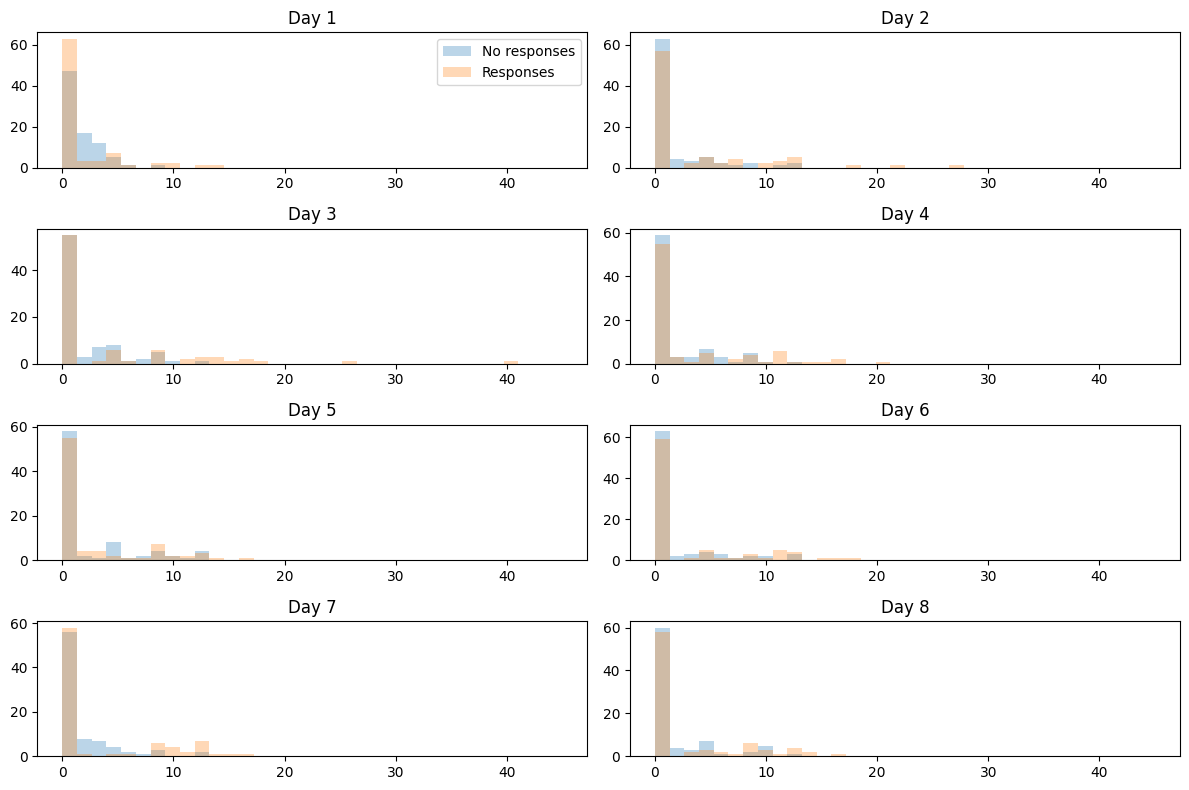

In [20]:
"""
Plot histograms of the number of responses and non-responses on each day of the trial

"""
from tqdm import tqdm

fig, axes = plt.subplots(4, 2, figsize=(12, 8))

bins = np.linspace(0, 45, 35)
hist_kw = {"bins": bins, "alpha": 0.3}
for day, axis in tqdm(zip(range(8), axes.ravel()), total=8):
    axis.set_title(f"Day {day + 1}")
    axis.hist(non_response_matrix[:, day], label="No responses", **hist_kw)
    axis.hist(response_matrix[:, day], label="Responses", **hist_kw)

axes[0, 0].legend()

fig.tight_layout()

Text(0, 0.5, 'Number of each response type')

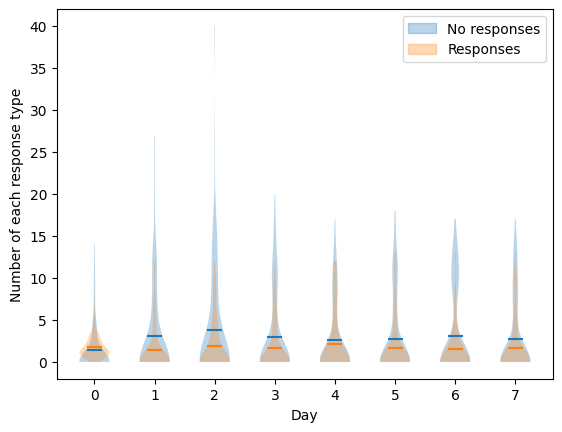

In [37]:
"""
On an axis, plot the distributions of responses and non-responses for each day of the trial

"""
import matplotlib.patches as mpatches

fig, axis = plt.subplots()

viol_kw = {
    "positions": np.arange(8),
    "showmeans": True,
    "showextrema": False,
}
non_response_viol = axis.violinplot(response_matrix, **viol_kw)
response_viol = axis.violinplot(non_response_matrix, **viol_kw)


labels = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

add_label(non_response_viol, "No responses")
add_label(response_viol, "Responses")
plt.legend(*zip(*labels))


axis.set_xlabel("Day")
axis.set_ylabel("Number of each response type")